In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from fastai.text.all import *
import glob

## 1. Train the Laugange Mode with the oversampling data

In [4]:
word_path = 'words_oversampled_bt.csv'
df_words = pd.read_csv(word_path)

,text


In [11]:
null_columns=df_words.columns[df_words.isnull().any()]
df_words[null_columns].isnull().sum()

text    6
dtype: int64

In [12]:
df_words = df_words.dropna(subset=['text'])
df_words.shape

(11234, 1)

In [13]:
# get the word model vocabulary
def get_questions(path):
    return df_words['text'].tolist()

dls_lm = DataBlock(
    blocks = TextBlock.from_df(df_words, is_lm=True),
    get_items=get_questions,
    splitter=RandomSplitter(0.2)
).dataloaders(word_path, bs=120)

# We get 4400 vocabulary
lm_vocab = dls_lm.vocab
len(lm_vocab), lm_vocab[-20:]

(4544,
 ['tax',
  'waiting',
  'prone',
  'whitin',
  'establish',
  '21',
  'techology',
  'somethin',
  'happing',
  'thechnology',
  'shi',
  'structures',
  'mundane',
  'soviet',
  'reuse',
  'zre',
  'xxfake',
  'xxfake',
  'xxfake',
  'xxfake'])

In [14]:
df_words.tail()

,text
11235,soI differ your worst tips ll ower old nipper doing their steay at habitation
11236,whah of bad bakshish for entertaining honestly to goodness schildren during theirs happily happily manage
11237,what appear yore deadly enemy foa hurting erstwhile childreans during thier hitch at home
11238,noct differ yoyur spoiled talents for harbour onetime CHILDREM during that visit a home
11239,Waht morw than bad steer made entertaining orl children during their arrest at larger


In [15]:
df_covid_vocabulary = pd.DataFrame(lm_vocab, columns=['vocab'])
df_covid_vocabulary.to_csv('covid_lm_vocab.csv', index=False)
df_covid_vocabulary

,vocab
0,xxunk
1,xxpad
2,xxbos
3,xxeos
4,xxfld
...,...
4539,zre
4540,xxfake
4541,xxfake
4542,xxfake


In [16]:
lm_learner = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

lm_learner.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,7.102335,5.911822,0.162635,369.378662,00:04


SuggestedLRs(valley=tensor(0.0030))

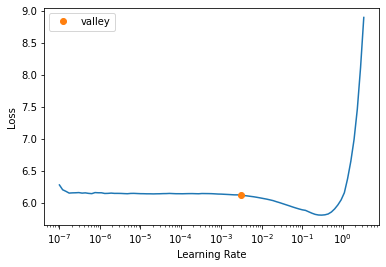

In [17]:
lm_learner.lr_find()

In [18]:
lm_learner.freeze_to(-2)
lm_learner.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.188118,5.652237,0.194888,284.928253,00:04


SuggestedLRs(valley=tensor(0.0001))

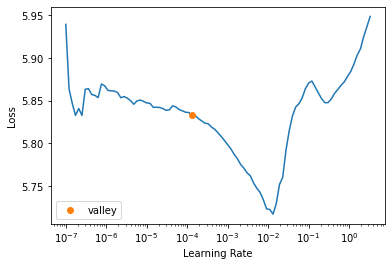

In [19]:
lm_learner.lr_find()

In [20]:
lm_learner.freeze_to(-3)
lm_learner.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.818279,5.626685,0.196296,277.739777,00:04


SuggestedLRs(valley=tensor(7.5858e-05))

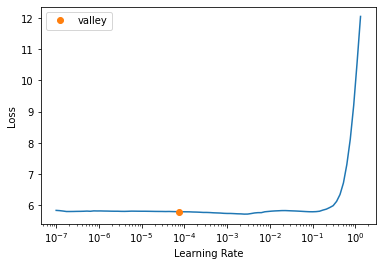

In [21]:
lm_learner.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.806459,5.621622,0.196142,276.337250,00:04
1,5.798668,5.600278,0.195949,270.501709,00:04
2,5.784911,5.568864,0.197242,262.136230,00:04
3,5.767083,5.541074,0.198746,254.951736,00:04
4,5.749382,5.522717,0.199228,250.314102,00:04
5,5.733768,5.509090,0.199730,246.926315,00:04
6,5.720606,5.499309,0.199904,244.522919,00:04
7,5.709253,5.493525,0.199981,243.112671,00:04
8,5.699833,5.491453,0.200154,242.609497,00:04
9,5.692200,5.491118,0.200135,242.528198,00:04


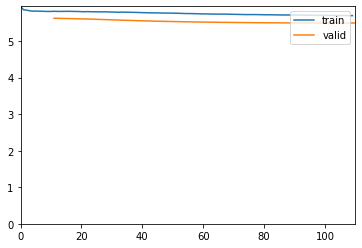

In [22]:
lm_learner.unfreeze()
lm_learner.fit_one_cycle(10, slice(7.5858e-05/(2.6**4),7.5858e-05),cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0002))

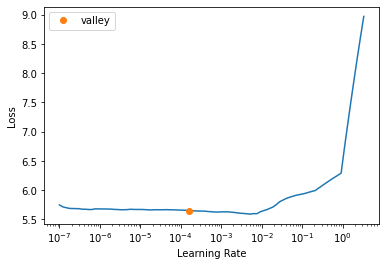

In [23]:
lm_learner.lr_find()

#### As we can see that the validation and train started deverge, it's time to stop training

In [24]:
lm_learner.save('lm_10epoch-os-bt')

Path('models/lm_10epoch-os-bt.pth')

In [25]:
lm_learner.save_encoder('lm_10epoch-os-bt-encoder')

In [26]:
lm_learner.export('lm_10epoch-os-bt.pkl')

Now I got my language mode trained and saved the encoder for later use when training the text classification mode.

In [27]:
TEXT = "where can I travel"
N_WORDS = 40
N_SENTENCES = 2
preds = [lm_learner.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]
print("\n".join(preds))

where can i travel from the United States to these countries what can i get i can the nod to his mother of you why will i miss him how oft you stay and issue another isuue what
where can i travel to see the plance cry the throne when the impact is why the funeral of the body is done performed the funeral for the deceased born except in the case of the funeral worker who died a thick matter


In [28]:
# Save the vocabulary from the language mode for text classification model
df_lm_vocab = pd.DataFrame(lm_vocab)
df_lm_vocab.to_csv('assets/lm_vocab.csv', index=False, header=None)

## 2. Training the Text Classification Model

**Make sure the ds files loaded in the sequence that my model training process expects**

So what does this mean?
Initially, I have my file named like this:

1. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_100.csv',
2. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_130.csv',
3. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_165.csv',
4. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_255.csv',
5. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_30.csv',
6. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_65.csv',
7. '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_81.csv'
 
And when we load the files using the `glob.glob()` method, it loads the model for categories which have more than 100 but less then 130 number of sampling data first, so the `all_file[0]` is actually the data set for categories 100-130, rather than the data set which has the categories which have less then 30 number of sampleing data!!!!

In [2]:
path = r'/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks' # use your path
all_files = glob.glob(path + "/ds_*.csv")

# check na
for fname in all_files:    
    df_labels = pd.read_csv(fname)

    null_columns=df_labels.columns[df_labels.isnull().any()]
    print(df_labels[null_columns].isnull().sum())

Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)


In [3]:
all_files

['/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_0_30.csv',
 '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_1_65.csv',
 '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_2_81.csv',
 '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_3_100.csv',
 '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_4_130.csv',
 '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_5_165.csv',
 '/media/winstonfan/Workspace/MyDoc/Interviews/DigitalVictoria/temp/covidfaqbot/datascience/notebooks/ds_6_255.csv']

In [4]:
df_lm_vocab = pd.read_csv('assets/lm_vocab.csv', header=None)
df_lm_vocab.columns = ['word']
lm_vocab = df_lm_vocab['word'].tolist()
lm_vocab

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'covid',
 'the',
 'to',
 'is',
 'what',
 'of',
 'how',
 'i',
 'a',
 'be',
 'for',
 'in',
 'are',
 'can',
 'will',
 'do',
 'it',
 'and',
 'from',
 'you',
 'that',
 'should',
 'pandemic',
 'if',
 'have',
 'why',
 '[',
 'on',
 'with',
 'virus',
 'get',
 'or',
 "'s",
 'china',
 'does',
 'there',
 'at',
 'who',
 'when',
 'my',
 'we',
 'people',
 'by',
 'was',
 'which',
 'as',
 'during',
 'an',
 'wherefore',
 'has',
 'did',
 's',
 'go',
 'than',
 'trump',
 'outbreak',
 'make',
 'world',
 'after',
 'kill',
 'us',
 'take',
 'virtus',
 'information',
 'vaccine',
 'nt',
 'spread',
 'come',
 'long',
 'not',
 ')',
 'symptoms',
 'live',
 'technology',
 'more',
 'your',
 'test',
 'so',
 'any',
 '(',
 'out',
 'lockdown',
 '.',
 'about',
 'where',
 'due',
 'health',
 'being',
 'risk',
 'haw',
 'against',
 'they',
 'o',
 'been',
 'could',
 'flu',
 'would',
 'between',
 'de',
 'way',
 'sanitizer',
 'safe',
 'e',
 

In [33]:
df_labels.shape, df_lm_vocab.shape, len(lm_vocab)

((208, 2), (4544, 1), 4544)

In [44]:
df_labels[:3]

,label,cid
0,Comparison - Black Death,0
1,Comparison - COVID and HIV,1
2,Comparison - COVID versus Flu Diagnosis,2


In [56]:
df_questions[:3]

,label,text,cid
0,Speculation - Pandemic Duration,will covid end soon,149
1,Speculation - Pandemic Duration,will covid end,149
2,Speculation - Pandemic Duration,when covid will be over,149


In [55]:
df_labels.shape, df_questions.shape

((208, 2), (6424, 3))

In [52]:
df_questions = pd.read_csv(ds_path)

null_columns=df_questions.columns[df_questions.isnull().any()]
df_questions[null_columns].isnull().sum()

Series([], dtype: float64)

In [57]:
ds_path = 'ql_oversampled_bt.csv'
# df_labels = pd.read_csv('labels.csv')

def getTextLabels(arg):
    df_questions = pd.read_csv(arg)
    return df_questions[['text', 'cid']]

textBlock = (TextBlock.from_df(text_cols = ['text'], vocab=lm_vocab),CategoryBlock)

dls_clas = DataBlock(
    blocks=textBlock,
    get_x = ColReader(cols='text'),
    get_y = ColReader(cols = "cid"),
    get_items= getTextLabels,
    splitter = TrainTestSplitter(test_size = 0.2, random_state = 21, stratify=df_questions["cid"])
).dataloaders(ds_path, bs=120)

df_q shape is (6424, 3)


/home/winstonfan/anaconda3/envs/fastai24/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


For precaution, we just show at least 2 records from each dataset to check whether the dataloaders are in the right sequence

In [58]:
dls_clas.valid.show_batch(max_n=2)

,text,category
0,xxbos xxunk the xxunk of one donald donald xxunk un resolution differ wihch family our regime as less but fom the speedy spred of atomic xxunk pandemic xxunk,115
1,xxbos can i raise there xxunk not f l xxunk in a open xxunk whose xxunk xxunk to xxunk world xxunk organization unmake non lack xxunk oil xxunk,182


### 2.1 Train the model for categories with less than 30 sampling data

In [59]:
# Now let's create the learner
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

learn = learn.load_encoder('lm_10epoch-os-bt-encoder')

dls_clas.show_batch(max_n=3)

,text,category
0,xxbos can xxmaj i ’ve talk ot thwe town dead brain ih is disagree in an xxunk elbow room i distant proximity to xxunk world heathy organization xxunk not xxunk information technology legally xxunk,182
1,xxbos shopuld china hole xxunk xxunk xxunk of irresponsible nations zhe nonfinancial free economical people xxunk s republik of china br well by xxunk distance sa a xxunk os pst severe pandemic xxunk,115
2,xxbos differ there any longer hazard of a first xxunk of covid xxunk xxunk xxunk wave of xxunk influenza xxunk which xxunk xxunk wellnes even s xxrep 3 o tle last wave xxunk,151


SuggestedLRs(valley=tensor(0.0036))

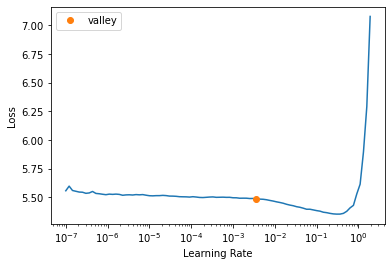

In [60]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,5.306332,5.151589,0.031907,00:01


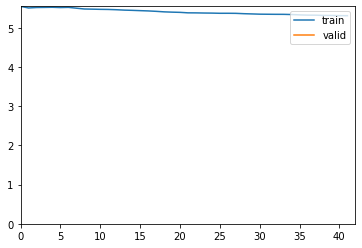

In [61]:
learn.fit_one_cycle(1, 3.6e-3,cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0036))

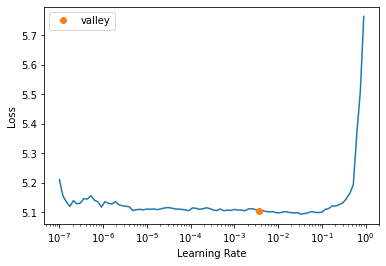

In [62]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,5.020917,4.838593,0.093385,00:01


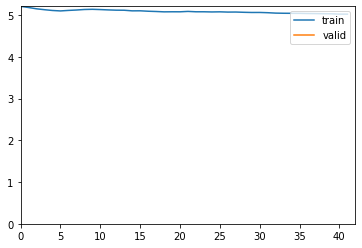

In [63]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 3.6e-3, cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0036))

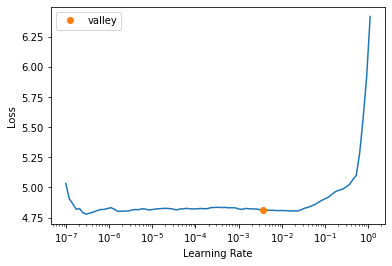

In [64]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,4.724994,4.525855,0.133074,00:01


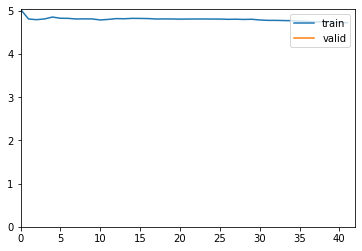

In [65]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 3.6e-3,cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0010))

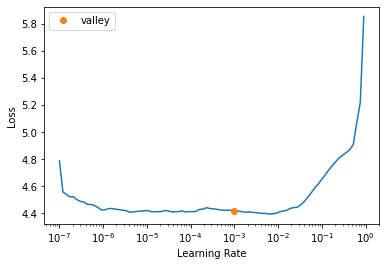

In [66]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,4.405231,4.488544,0.161868,00:01
1,4.322658,4.279111,0.194553,00:01
2,4.147004,4.042177,0.232685,00:01
3,3.942216,3.825095,0.271595,00:01
4,3.711567,3.647549,0.301946,00:01
5,3.480996,3.542534,0.333852,00:01
6,3.295562,3.435197,0.341634,00:01
7,3.137581,3.383941,0.351751,00:01
8,3.030714,3.360006,0.361089,00:01
9,2.966390,3.374930,0.361868,00:01


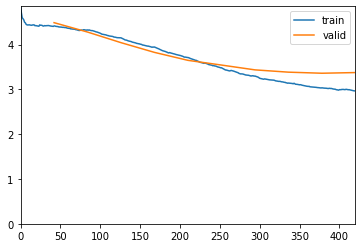

In [67]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4), 1e-3), cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(4.3652e-05))

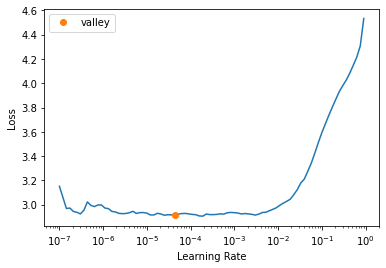

In [68]:
learn.lr_find()

In [69]:
learn.export('models/10epoch.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,0.529656,0.578794,0.966480,00:01
1,0.502250,0.471571,0.969274,00:01
2,0.461235,0.372591,0.969274,00:01
3,0.410270,0.323309,0.974860,00:01
4,0.361484,0.293114,0.969274,00:01
5,0.318966,0.275410,0.966480,00:01
6,0.284176,0.263049,0.972067,00:01
7,0.251409,0.257824,0.972067,00:01
8,0.226594,0.256947,0.974860,00:01
9,0.207944,0.257716,0.972067,00:01


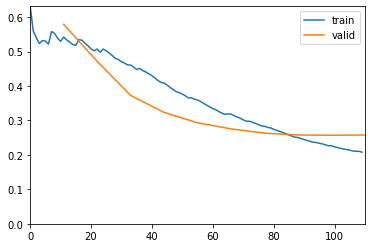

In [19]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1.7e-3/(2.6**4),1.7e-3),cbs=[ShowGraphCallback()])

SuggestedLRs(valley=tensor(0.0010))

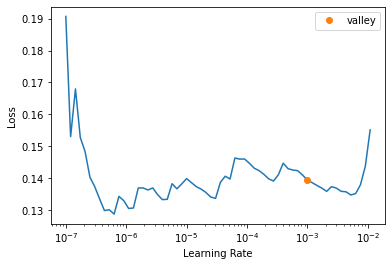

In [20]:
learn.lr_find()

The LR finding has lost its form, so stop here.
Now let's try this trained model

In [70]:
learn.predict('did the covid pandemic make you realize anything about yourself that you didnt already know')

('116',
 tensor(116),
 tensor([4.9280e-03, 8.9015e-04, 4.1539e-03, 9.5750e-04, 4.5311e-03, 5.8685e-04,
         6.9980e-04, 1.0494e-02, 1.6160e-03, 2.7166e-02, 5.5102e-04, 6.4642e-04,
         3.1818e-03, 2.3963e-05, 4.2269e-04, 4.2084e-04, 1.5919e-04, 8.4960e-04,
         6.6726e-04, 4.3846e-04, 9.0926e-04, 1.6001e-02, 2.0087e-03, 7.3249e-04,
         4.4002e-03, 1.2433e-03, 2.6589e-02, 4.6749e-03, 1.3266e-02, 4.7764e-03,
         8.5124e-05, 1.2365e-02, 4.8842e-04, 3.1015e-04, 4.8747e-04, 1.3082e-04,
         2.6433e-02, 6.4905e-03, 1.4799e-02, 1.7805e-03, 4.2482e-03, 1.4154e-03,
         6.4274e-03, 5.0245e-04, 2.2303e-02, 9.5923e-03, 4.2899e-03, 3.7162e-03,
         3.2036e-03, 2.9861e-03, 4.2559e-04, 1.7589e-03, 5.4834e-04, 1.3968e-03,
         2.8647e-03, 1.0203e-03, 1.8514e-03, 2.1435e-03, 5.6006e-03, 3.1289e-04,
         1.9727e-03, 2.2029e-03, 8.2759e-04, 3.7864e-02, 1.0228e-04, 1.9164e-04,
         2.2691e-04, 6.6792e-04, 5.6768e-04, 1.2720e-03, 1.3728e-03, 1.5205e-04,
      

In [71]:
learn.predict('how does being a smoker impact covid patient outcomes')

('177',
 tensor(177),
 tensor([0.0006, 0.0030, 0.0076, 0.0032, 0.0036, 0.0045, 0.0042, 0.0034, 0.0016,
         0.0033, 0.0012, 0.0015, 0.0023, 0.0019, 0.0008, 0.0009, 0.0005, 0.0017,
         0.0009, 0.0014, 0.0007, 0.0120, 0.0037, 0.0031, 0.0017, 0.0020, 0.0029,
         0.0035, 0.0053, 0.0066, 0.0036, 0.0125, 0.0026, 0.0012, 0.0013, 0.0036,
         0.0024, 0.0027, 0.0056, 0.0002, 0.0090, 0.0112, 0.0079, 0.0048, 0.0094,
         0.0021, 0.0009, 0.0016, 0.0013, 0.0009, 0.0003, 0.0044, 0.0017, 0.0040,
         0.0031, 0.0019, 0.0010, 0.0014, 0.0023, 0.0032, 0.0007, 0.0031, 0.0031,
         0.0023, 0.0055, 0.0023, 0.0014, 0.0094, 0.0051, 0.0011, 0.0028, 0.0008,
         0.0065, 0.0155, 0.0004, 0.0021, 0.0024, 0.0017, 0.0050, 0.0040, 0.0017,
         0.0104, 0.0118, 0.0017, 0.0032, 0.0179, 0.0040, 0.0029, 0.0021, 0.0006,
         0.0016, 0.0013, 0.0020, 0.0004, 0.0028, 0.0007, 0.0007, 0.0058, 0.0015,
         0.0007, 0.0003, 0.0007, 0.0050, 0.0023, 0.0003, 0.0012, 0.0039, 0.0005,
      